<a id = 'top'></a>

[Configure Notebook](#configure)  
***

# Cross-trial aligment checks by cell  
###### For each ROI Plot average displacement normalized to roi radius as mask.

We find a trial where we know each cell is well represented by its mask. We then assume that any FOV displacement will cause the local neighborhood around the mask to shift uniformly. If the cell doesn’t move under the mask, then we should be able to reliably identify it in the local neighborhood across the experiment. To quantify displacement, we can cross correlate the small representative mask to its larger neighborhood across time.  Periods where the displacement between correlation peaks is greater than half the mask diameter can be isolated and excluded.

 
>[Calculate displacement for each ROI](#calculate)  
>[Plot](#plot)  
>[FNCC functions](#functions)  



##### Set Paths

In [2]:
experiment = 'sp101716a'

qcGitDir = '/Users/Stan/Documents/myPiriform/notebooks/qc/{0}/'.format(experiment)
sframePath = '/Users/Stan/Desktop/{0}/segmentation_slice_1/tracesDFfromTrial/sframe_slice_1_processed'.format(experiment)

#rawTraces_e1_Path = '/Users/Stan/Desktop/{0}/e1_traces_dict.dat'.format(experiment)
#rawTraces_e2_Path = '/Users/Stan/Desktop/{0}/e2_traces_dict.dat'.format(experiment)
#workflowDict_e1_Path = '/Users/Stan/Desktop/{0}/workflow_dict_e1.dat'.format(experiment)
workflowDict_e2_slice_1_Path = '/Users/Stan/Desktop/{0}/workflow_dicts/workflow_dict_e2_slice1.dat'.format(experiment)
workflowDict_e2_slice_2_Path = '/Users/Stan/Desktop/{0}/workflow_dicts/workflow_dict_e2_slice2.dat'.format(experiment)
odorPath = '/Users/Stan/Desktop/{0}/odorInfo_e2.dat'.format(experiment)
maskPath_slice_1 = '/Users/Stan/Desktop/{0}/segmentation/sp101716a_slice_1_maskSoFar.dat'.format(experiment)
maskPath_slice_4 = '/Users/Stan/Desktop/{0}/segmentation/sp101716a_slice_4_maskSoFar.dat'.format(experiment)
h5FnamesDir_slice_1 = '/Users/Stan/Desktop/{0}/h5/red/slice_1/'.format(experiment)
h5FnamesDir_slice_4 = '/Users/Stan/Desktop/{0}/h5/red/slice_4/'.format(experiment)

##### Munge Data: combine raw version of trial with aligned version in one h5 file. 

In [5]:
alignedfname

'/Users/Stan/Desktop/sp101716a/h5/red/slice_4/_e2_014_concatenated.h5'

In [6]:
rawfname

'/Users/Stan/Desktop/sp101716a/h5/red/slice_4/raw/_e2_014_concatenated.h5'

In [ ]:
# for alignedfname in glob(alignedPath + '*.h5'):
#     with h5py.File(alignedfname, 'r+') as f:
#             del f['raw']

In [14]:
alignedPath = h5FnamesDir_slice_4
rawPath = h5FnamesDir_slice_4 + 'raw/'

pairs = zip(glob(alignedPath + '*.h5'), glob(rawPath + '*.h5'))

for alignedfname,rawfname in pairs:
    trialID_raw = re.split('/|concat', rawfname)[-2]
    trialID_aligned = re.split('/|concat', alignedfname)[-2]
    
    with h5py.File(rawfname, 'r+') as r:
        raw = r[trialID_raw][...]

    if trialID_raw != trialID_aligned:
        print trialID_raw, trialID_aligned, '  failed'
    try:
        with h5py.File(alignedfname, 'r+') as f:
            f['raw'] = raw
    except: 
        print 'write error:  ', alignedfname
        pass

##### Load mask and odor info

In [15]:
#sframe = gl.SFrame(sframePath)
#trialFname = '_e2_007_'
#fname = '/Users/Stan/Desktop/{0}/h5/red/slice_1/{1}'.format(experiment)
mask = pickle.load(open(maskPath_slice_4)).astype(int)

odorInfo = pickle.load(open(odorPath))

fnames = glob(h5FnamesDir_slice_4 + '*.h5')
targetfname = fnames[6]

good_trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14] # that is...trials in odor_info or ones with no motion artifacts

<a id = 'calculate'></a>
##### Calculate cross-trial displacement
[back to top](#top)

In [25]:
from scipy.ndimage.measurements import center_of_mass as get_coords

mask = mask.astype(int)
odor=3
numCells = mask.max()

#get cell coords
coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
coords[0]=(100,100)
coords = [(t[1],t[0]) for t in coords]

# #Make 1 dfs for aligned version. 
# #get area, radius, roi coords, 
# #get FNCC results
dfs = []
for alignmentStatus, condition in {'1':True,'0':False}.items():
    resultsDict  = {}   
    for cell in range(numCells)[:]:
        scores, argmax_coords, EucDist, AveEucDisplacement = runFNCC(mask, odor=3, cell=cell, 
                                                                     fnames=fnames, targetFname=targetfname,
                                                                     aligned = condition, trialsToUse = good_trials)
        
        area = len(mask[mask==cell])
        radius = (np.power(area/np.pi,0.5))
        
        resultsDict[cell] = dict(scores = scores,
                                argmax_coords = argmax_coords,
                                EucDist = EucDist,
                                AveEucDisplacement = AveEucDisplacement,
                                Coords = coords[cell],
                                area = area,
                                radius = radius)
    
    df = pd.DataFrame(resultsDict).T
    df['aligned'] = alignmentStatus
    df['odor'] = odor
    dfs.append(df)
df = pd.concat(dfs) 

df.index.rename('cellID', inplace=True)
df.reset_index(inplace=True)
df = df.replace('exclude', np.nan)    


df['AveEucDisplacementNormed'] = df.apply(lambda x: x.AveEucDisplacement/x.radius, axis = 1)

Exception: cell 0, -25  neighborhood outside image
Exception: cell 1, -4  neighborhood outside image
Exception: cell 8, -4  neighborhood outside image
Exception: cell 9, -12  neighborhood outside image
Exception: cell 10, -10  neighborhood outside image
Exception: cell 13, -13  neighborhood outside image
Exception: cell 14, -1  neighborhood outside image
Exception: cell 15, -17  neighborhood outside image
Exception: cell 22, 270  neighborhood outside image
Exception: cell 25, -5  neighborhood outside image
Exception: cell 26, -19  neighborhood outside image
Exception: cell 27, -12  neighborhood outside image
Exception: cell 29, 262  neighborhood outside image
Exception: cell 30, 270  neighborhood outside image
Exception: cell 33, 267  neighborhood outside image
Exception: cell 43, 270  neighborhood outside image
Exception: cell 0, -25  neighborhood outside image
Exception: cell 1, -4  neighborhood outside image
Exception: cell 8, -4  neighborhood outside image
Exception: cell 9, -12  n

<a id = 'plot'></a>
##### Superimpose average ROI displacement on mask
[back to top](#top)

In [ ]:
#above returns scores, argmax_coords, EucDist, AveEucDisplacement

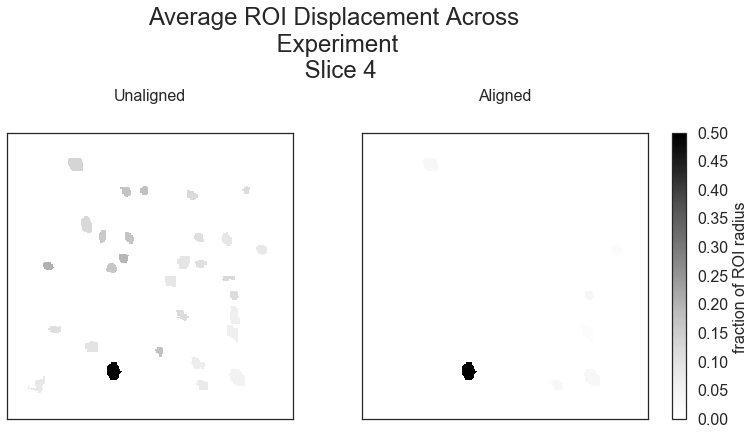

In [27]:

#get cells where there are non NANs
GoodCells = df.cellID[df.AveEucDisplacementNormed.apply(np.isfinite)].unique()

#Format Figure
f,(ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
f.suptitle('Average ROI Displacement Across \n Experiment \n Slice 4', fontsize=24, x=0.5, y=1.2)

for alignmentStatus, ax, title in [('0',ax1,'Unaligned'), ('1',ax2, 'Aligned')]:
    #Make mask to plot
    masktoPlot = np.zeros_like(mask).astype(float)
    for cell in GoodCells:
        fracofRad = df[df.cellID==cell][df.aligned==alignmentStatus].AveEucDisplacementNormed.values[0]
        masktoPlot[mask==cell]=float(fracofRad)
        
    #plot and format each plot
    image = ax.imshow(masktoPlot, vmax = .5)
    image.axes.get_xaxis().set_visible(False)
    image.axes.get_yaxis().set_visible(False)
    ax.set_title(title, fontsize = 16, y = 1.1)
    if title == 'Aligned':
        cbar = plt.colorbar(image)
        cbar.set_label('fraction of ROI radius', fontsize = 16)
    plt.tight_layout()
plt.savefig(qcGitDir + 'alignmentMaskBeforeAfter_slice_4.png',bbox_inches='tight', pad_inches=0.5 )

<a id = 'functions'></a>
##### Define FNCC Functions
[back to top](#top)

In [24]:

def runFNCC(mask, odor, cell, fnames, targetFname,  aligned = False, trialsToUse = good_trials):
    from skimage.feature import match_template
    """
    We load the preprocessed red channel neighborhood for a cell-odor pair for all trials. We then calculate 
    the displacement of the peak from a reference trial across all other trials. 
    """
    
    odor = odor
    cell = cell

    coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
    coords[0]=(0.0,0.0)
    coords = [(int(t[1]),int(t[0])) for t in coords]

    #Specify dimensions  of local neighborhood
    halfRad = 25
    yi = coords[cell][1]-halfRad
    yf = coords[cell][1]+halfRad
    xi = coords[cell][0]-halfRad
    xf = coords[cell][0]+halfRad
    
    #Edge Exception. Return's None for cells on the edge. 
    for _ in [yi, yf, xi,xf]:
        if _<0 or _>256:
            print 'Exception: ' 'cell {},'.format(cell), _, " neighborhood outside image"
            return 'exclude', 'exclude', 'exclude', 'exclude' 
    #Specify dimensions of target 
    xstart = 10
    ystart = 10
    targetW = 30
    targetH = 30
    
    #load target 
    epoch,trialID = [int(_) for _ in re.split('_e|_con|_',targetfname)[-3:-1]]
    odorInfotrialIDX = trialID-1
    targetKey = re.split('/|concat', targetfname)[-2]
    odorFrames_i, odorFrames_f = odorInfo['epoch{}'.format(epoch)][odorInfotrialIDX]['pre_odor_post_interval'][odor]
    with h5py.File(targetFname, 'r+') as f:    
        target = f[targetKey][yi:yf,xi:xf, odorFrames_i:odorFrames_f]  
        
    #Make actual target
    actualTarget = target[xstart:xstart+targetW, ystart:ystart+targetH]
    actualTarget = actualTarget.mean(2)


    #Make Mask Overlay
    overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))

    #Run target search on all trials
    scores = []
    argmax_coords = []
    EucDist = []    
    for fname in fnames:
        fnameKey = re.split('/|concat', fname)[-2]
        if aligned == False:
            fnameKey = 'raw'
        epoch,trialID = [int(_) for _ in re.split('_e|_con|_',fname)[-3:-1]]
         
        if trialID not in trialsToUse:
            continue
        
        #get odor Info
        odorFrames_i, odorFrames_f = [odorInfo['epoch{}'.format(epoch)][_] for _ in range(len(odorInfo['epoch{}'.format(epoch)]))
        if odorInfo['epoch{}'.format(epoch)][_]['trialID']==trialID][0]['pre_odor_post_interval'][odor]
        #Load trial neighborhood
        with h5py.File(fname, 'r+') as f:    
            trial = f[fnameKey][yi:yf,xi:xf, odorFrames_i:odorFrames_f].mean(2)

        #Execute Fast normalized cross-correlation
        result = match_template(trial, actualTarget)
        

        #Obtain correlation values
        i,j = np.unravel_index(np.argmax(result),result.shape)
        scores.append(result[i,j])
        argmax_coords.append((i,j))

        #Obtain average Euclidian distance
        from scipy.spatial import distance
        EucDist.append(distance.pdist(np.array([(10,10),(i,j)]),'euclidean'))
    AveEucDisplacement = np.vstack(EucDist).mean()
    return scores, argmax_coords, EucDist, AveEucDisplacement


def runFNCConCorr(mask, odor, cell, fnames, targetFname, key = 'current_statestep2/corrected' ):
    from skimage.feature import match_template
    from sklearn.preprocessing import scale
    """
    We load the preprocessed red channel neighborhood for a cell-odor pair for all trials. We then calculate 
    the displacement of the peak from a reference trial across all other trials. 
    """
    
    odor = odor
    cell = cell

    coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
    coords[0]=(0.0,0.0)
    coords = [(int(t[1]),int(t[0])) for t in coords]

    #Specify dimensions  of local neighborhood
    halfRad = 25
    yi = coords[cell][1]-halfRad
    yf = coords[cell][1]+halfRad
    xi = coords[cell][0]-halfRad
    xf = coords[cell][0]+halfRad
    
    #Edge Exception. Return's None for cells on the edge. 
    for _ in [yi, yf, xi,xf]:
        if _<0 or _>512:
            print 'Exception: ' 'cell {},'.format(cell), _, " neighborhood outside image"
            return 'exclude', 'exclude', 'exclude', 'exclude' 
    #Specify dimensions of target 
    xstart = 10
    ystart = 10
    targetW = 30
    targetH = 30
    
    #load target 
    epoch,trialID = [int(_) for _ in re.split('_e|_con|_',targetfname)[-3:-1]]
    odorFrames_i, odorFrames_f = odorInfo['epoch{}'.format(epoch)][trialID-1]['pre_odor_post_interval'][odor]
    with h5py.File(targetFname, 'r+') as f:    
        target = f[key][yi:yf,xi:xf, odorFrames_i:odorFrames_f] 
    #Correlate
    h,w,numFrames = target.shape
    corrWin = 2
    #scale each frame
    scaled = np.empty((h,w,numFrames))
    for i, frame in enumerate([scale(target[...,frame]) for frame in range(numFrames)]):
        scaled[...,i] = frame
    #Correlate    
    targetCorr = np.empty((h,w))
    for i in range(0,h):
        for j in range(0,w):
            targetCorr[i,j] = np.correlate(scaled[i,j,:],scaled[i-corrWin:i+corrWin, j-corrWin:j+corrWin,:].mean(0).mean(0))

        
    #Make actual target
    actualTarget = targetCorr[xstart:xstart+targetW, ystart:ystart+targetH]
    #actualTarget = actualTarget.mean(2)
    

    #Make Mask Overlay
    overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))

    #Run target search on all trials
    scores = []
    argmax_coords = []
    EucDist = []    
    for ifname, fname in enumerate(fnames):
        epoch,trialID = [int(_) for _ in re.split('_e|_con|_',fname)[-3:-1]]
        #get odor Info
        odorFrames_i, odorFrames_f = odorInfo['epoch{}'.format(epoch)][trialID-1]['pre_odor_post_interval'][odor]

        #Load trial neighborhood
        with h5py.File(fname, 'r+') as f:    
            trial = f[key][yi:yf,xi:xf, odorFrames_i:odorFrames_f]
        #Correlate
        h,w,numFrames = trial.shape
        corrWin = 2
        #scale each frame
        scaled = np.empty((h,w,numFrames))
        for i, frame in enumerate([scale(trial[...,frame]) for frame in range(numFrames)]):
            scaled[...,i] = frame
        #Correlate    
        trial = np.empty((h,w))
        for i in range(0,h):
            for j in range(0,w):
                trial[i,j] = np.correlate(scaled[i,j,:],scaled[i-corrWin:i+corrWin, j-corrWin:j+corrWin,:].mean(0).mean(0))
        #fix NAN values
        trial=np.nan_to_num(trial)
        trial[trial==0] = trial[corrWin:,corrWin].flatten().mean()
        #Execute Fast normalized cross-correlation
        result = match_template(trial, actualTarget)
#         if ifname ==1:
#             return trial, actualTarget

        #Obtain correlation values
        i,j = np.unravel_index(np.argmax(result),result.shape)
        scores.append(result[i,j])
        argmax_coords.append((i,j))
        
        #Obtain average Euclidian distance
        from scipy.spatial import distance
        EucDist.append(distance.pdist(np.array([(10,10),(i,j)]),'euclidean'))
    AveEucDisplacement = np.vstack(EucDist).mean()
    return scores, argmax_coords, EucDist, AveEucDisplacement

<a id = 'configure'></a>
##### Configure Notebook
[back to top](#top)

In [1]:

import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import numpy as np

from d_code.imaging.io import tifffile
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from collections import defaultdict
from scipy import signal
from time import time
import cPickle as pickle
import spUtils
import seaborn as sns
import h5py
import re
import graphlab as gl
gl.canvas.set_target('ipynb')
import pandas as pd

sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#style notebook
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479082498.log


This non-commercial license of GraphLab Create for academic use is assigned to stanlp86@gmail.com and will expire on November 04, 2017.
